<a href="https://colab.research.google.com/github/shreeganeshasharma/ParticleSimulations/blob/main/2DWithoutPores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
Source : https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.240601
___

Aim : To simulate distribution of mean first passage times in 2D Heterogeneous media

Author : Shree Ganesha Sharma.M.S

Date : 14-April-2023

# Initialization, D1 = 1, D2 = 10

In [12]:
"""
Aim : To simulate distribution of mean first passage times in 2D Heterogeneous media
Source : https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.240601
Author : Shree Ganesha Sharma.M.S
Date : 14-April-2023
"""
#necessary libraries
import time
import math
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
np.random.seed(2131)

#Brownian motion parameters
#Dimensions - 1, 2 or 3
dim = 2
#Time step
dt = 0.001
#Number of steps
nums = 1000
#Number of particles
nump = 1000
#Radius of the inner ball, reflecting boundary with pores
R1 = 0.5
#Radius of the outer ball, completely reflecting boundary
R2 = 1
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 10

#Radius of the target at the center
R = R1 / 5
"""Get r0 value from paper"""
#Hitting times if the target is hit
hittingTime = np.zeros(nump)

#Parameters of the normal distribution
mean = np.zeros(dim)
covar = np.identity(dim)

#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

#Random steps
Eps = np.random.multivariate_normal(mean, covar, (nump, nums))
dX1s = np.sqrt(2*D1*dt)*Eps
dX2s = np.sqrt(2*D2*dt)*Eps

#nump particles starting at init
Init1D = np.tile(np.array([.2]), nump)
Init2D = np.tile(np.array([[.2], [0]]), nump)
Init3D = np.tile(np.array([[.2], [0], [0]]), nump)

"""Initialize X[:, 0] here
Initialize counts for t=0"""

'Initialize X[:, 0] here\nInitialize counts for t=0'

#Simulate Ito Convention

In [13]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      """To do - Remove the particle once it hits the target, how to do?"""
      #X[:, j+1:] = np.transpose(np.tile(X[:, j - 1] + dX1, (nums-(j+1), 1)))
      """This seems to work as it won't be plotted in  a [0, 1] grid"""
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle is currently in medium1, travels without hitting the target - might stay in D1 or diffuse to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1):
      X[:, j] = X[:, j - 1] + dX1

    #Particle is currently in medium2, (almost) never hits the target directly from D2, might stay in D2 or diffuse to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 14.40330719947815 seconds ---


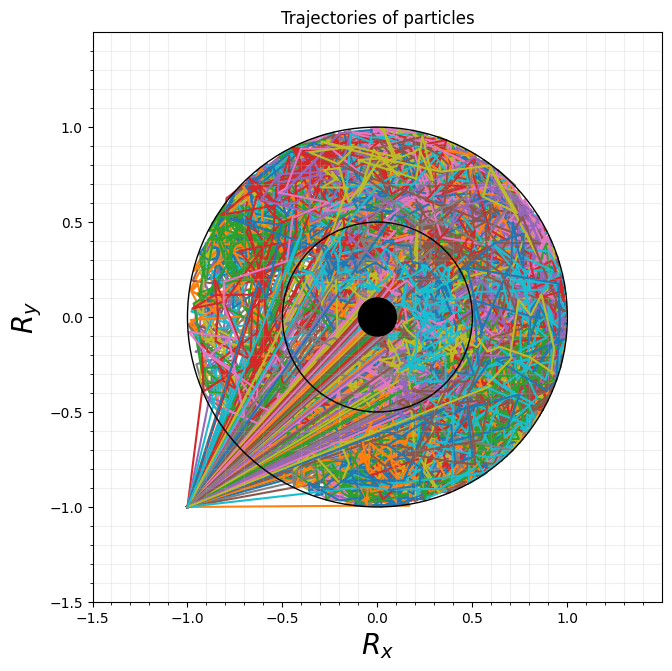

In [14]:
#WHy are some trajectories going out of the R2 boundary?

#set plot params
box=3*R2
fig,ax=plt.subplots(figsize=(7.5,7.4))
ax.set_aspect(1)
ax.set_title("Trajectories of particles")
ax.set_xlabel(r"$R_x$",fontsize=20)
ax.set_ylabel(r"$R_y$",fontsize=20)
plt.xlim(-box/2,box/2)
plt.ylim(-box/2,box/2)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-box/2, box/2, box/6)
minor_ticks = np.arange(-box/2, box/2, box/30)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid()

for i in range(nump):
  plt.plot(Y[0, :, i], Y[1, :, i], zorder=1)

ax.add_artist(plt.Circle((0, 0), R1, fill = False, zorder=2))
ax.add_artist(plt.Circle((0, 0), R2, fill = False, zorder=3))
ax.add_artist(plt.Circle((0, 0), R, fill = True, color = "k", zorder = 4))
plt.show()
#Higher zorder means the plot is on top
#https://www.pythonpool.com/matplotlib-circle/
#https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot

# Plots

Mean First Passage Time =  24.784313725490197


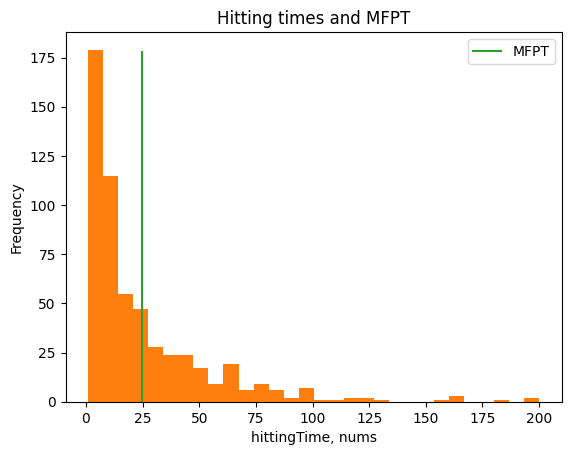

In [15]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

In [16]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

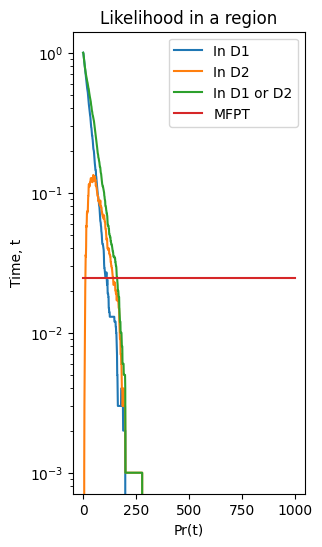

In [17]:
xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

#At dt = 0.001 and nums = 1000, nump = 5000,
#Half the number of particles are still in D1 at the end of simulation.
#Increase dt to 0.01
#Gaphs look similar

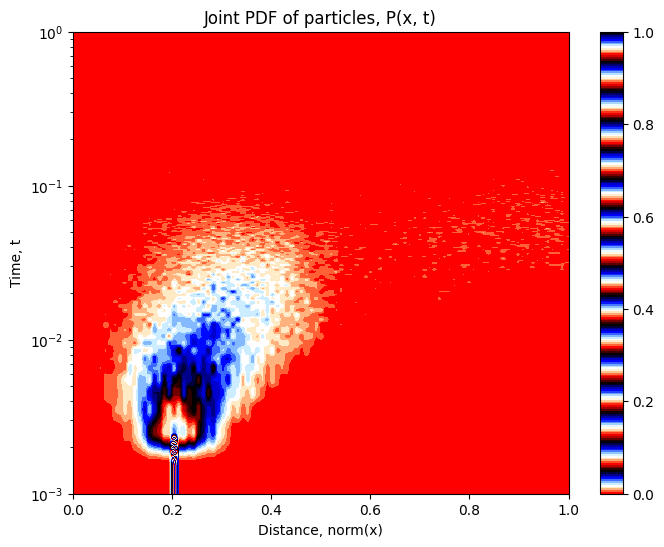

In [18]:
#Plot heatmap of particles over time and space

"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum

#https://note.nkmk.me/en/python-numpy-count/
#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw
#Which colormap facilitates distinction?"""

gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [19]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 8.193705558776855 seconds ---


# Plots

Mean First Passage Time =  187.890756302521


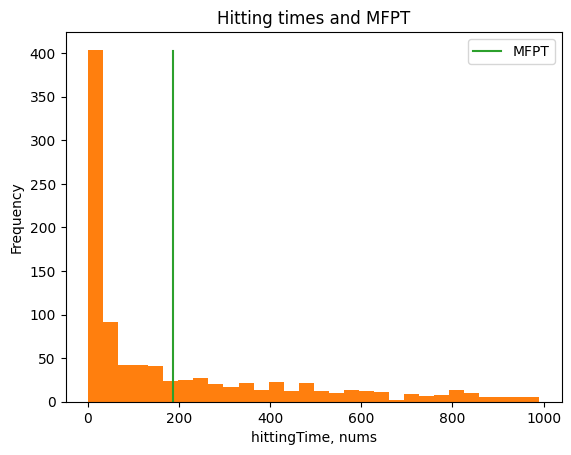

In [20]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

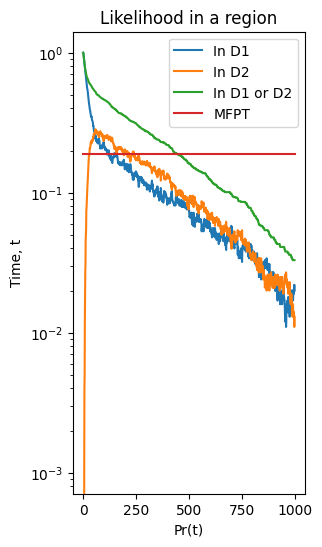

In [21]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    """Here it matters if I set a hitting particle to -1 or stick it there"""
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

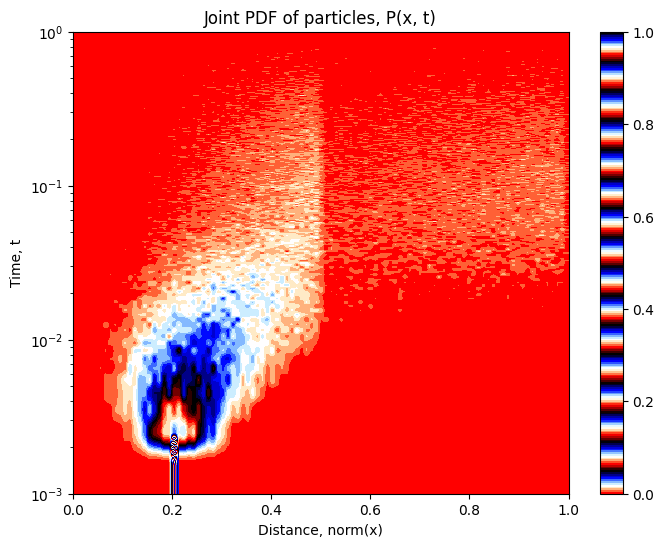

In [22]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')

# Simulate Isothermal Convention

In [23]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1-lamb)*np.dot(dX1, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1-lamb)*np.dot(dX2, r0/np.linalg.norm(r0))*r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 19.624723434448242 seconds ---


# Plots

Mean First Passage Time =  187.74599260172627


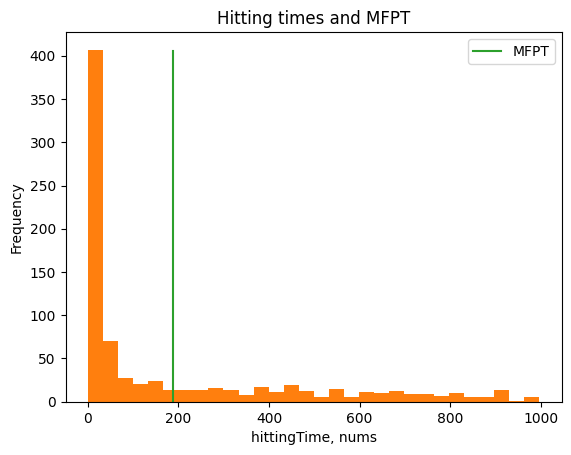

In [24]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

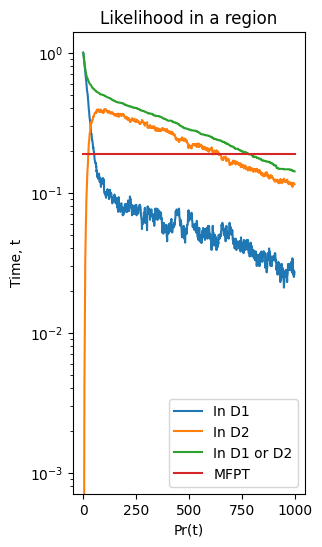

In [25]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

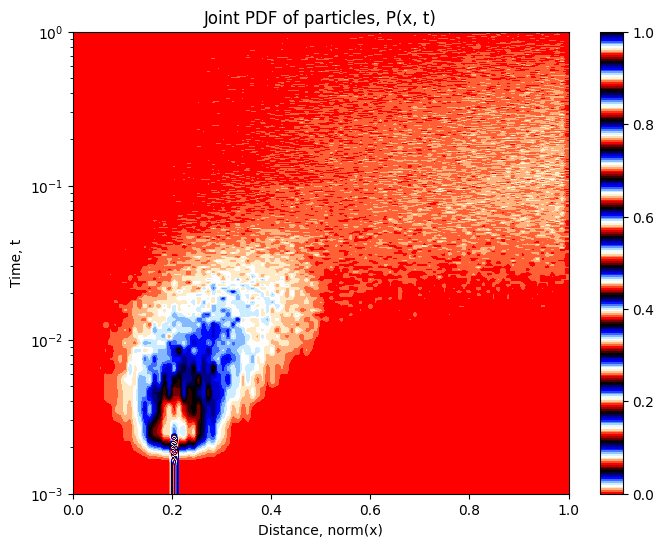

In [26]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Iso_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1, D2 = 1.1

#Simulate Ito Convention

In [27]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 1.1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [28]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 5.1706719398498535 seconds ---


# Plots

Mean First Passage Time =  128.77304964539007


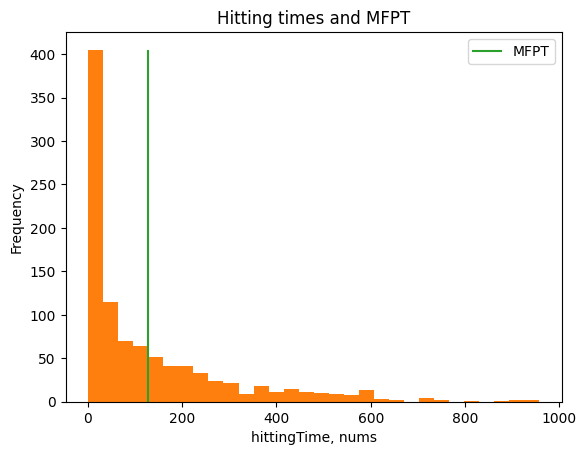

In [29]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

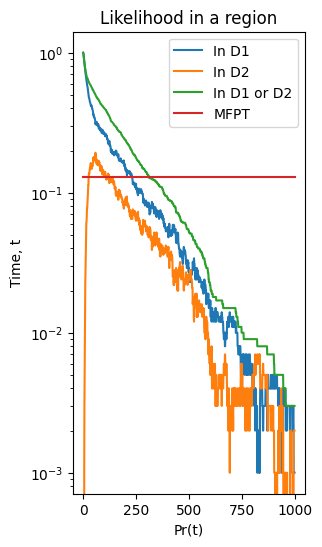

In [30]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

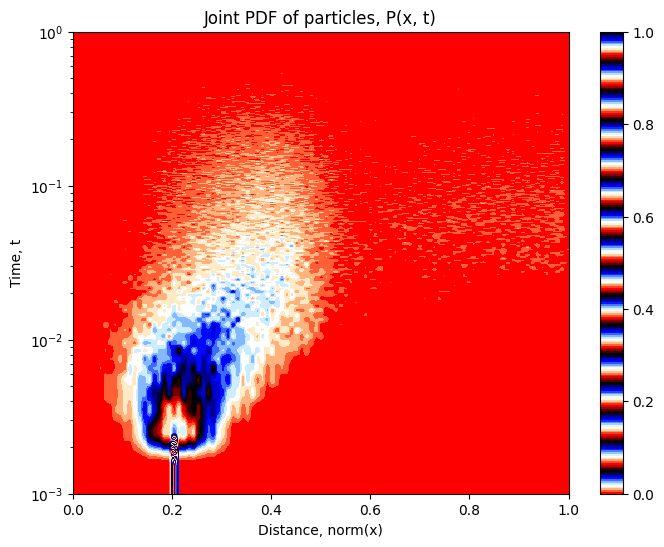

In [31]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [32]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 5.392740249633789 seconds ---


# Plots

Mean First Passage Time =  163.34397528321318


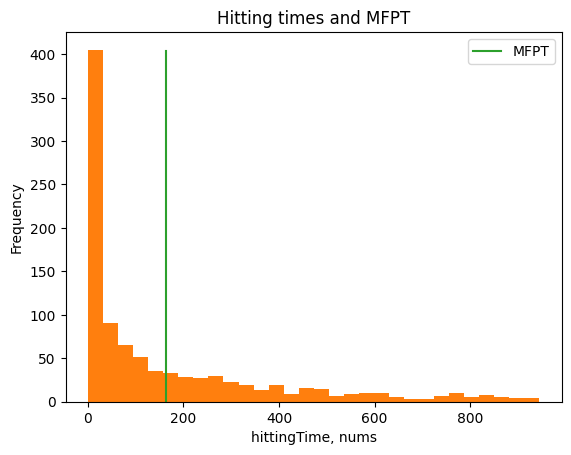

In [33]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

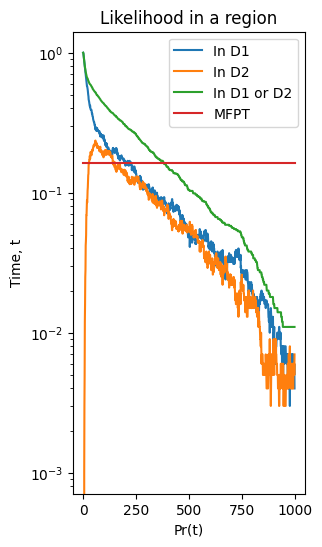

In [34]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

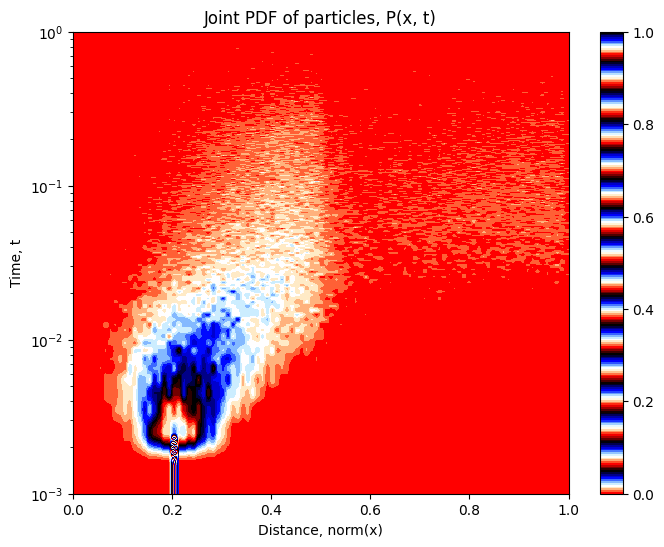

In [35]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [36]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 10.246370553970337 seconds ---


# Plots

Mean First Passage Time =  166.6197327852004


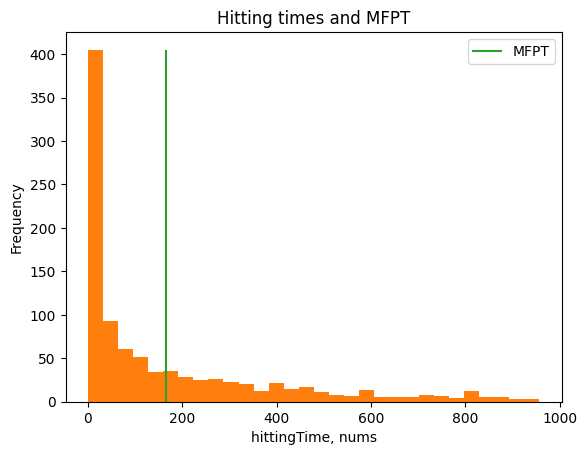

In [37]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

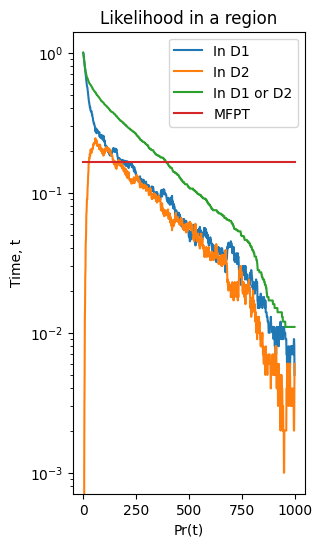

In [38]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

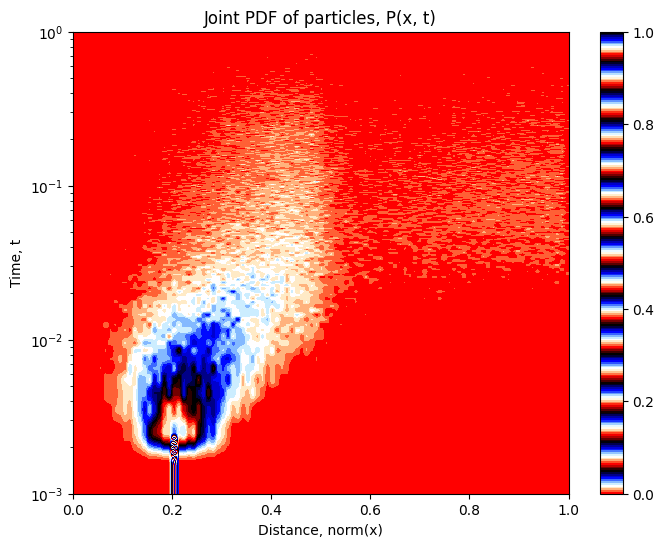

In [39]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1, D2 = 1

#Simulate Ito Convention

In [40]:
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [41]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 4.792464971542358 seconds ---


# Plots

Mean First Passage Time =  128.77304964539007


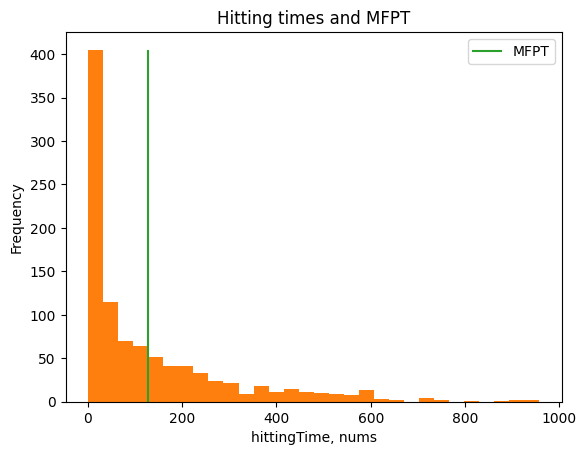

In [42]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

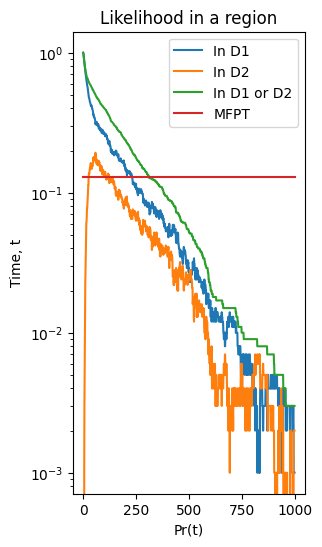

In [43]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

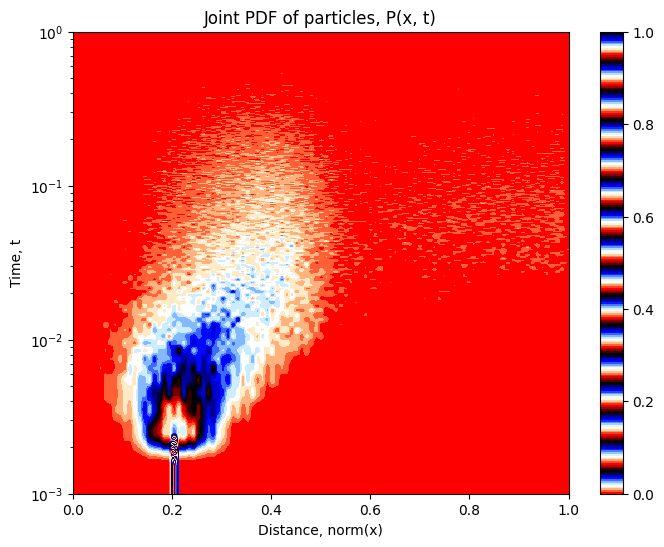

In [44]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [45]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 5.057037115097046 seconds ---


# Plots

Mean First Passage Time =  160.11668372569088


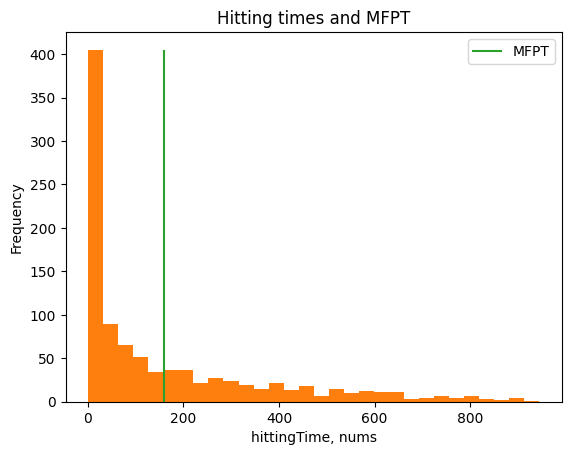

In [46]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

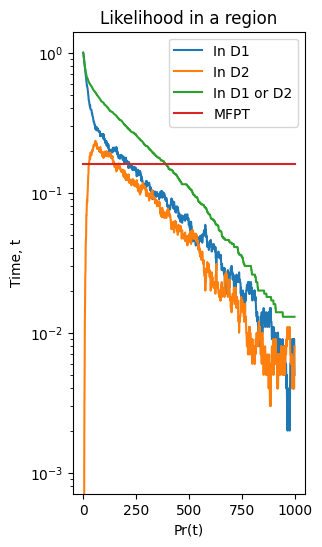

In [47]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

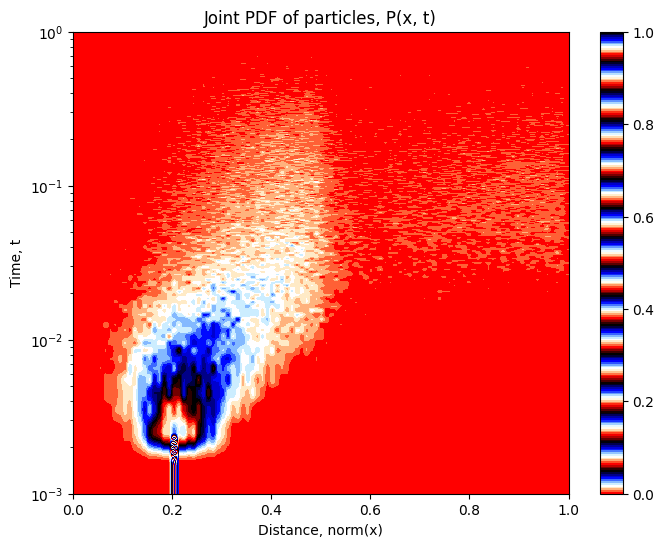

In [48]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [49]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 9.755533695220947 seconds ---


# Plots

Mean First Passage Time =  160.11668372569088


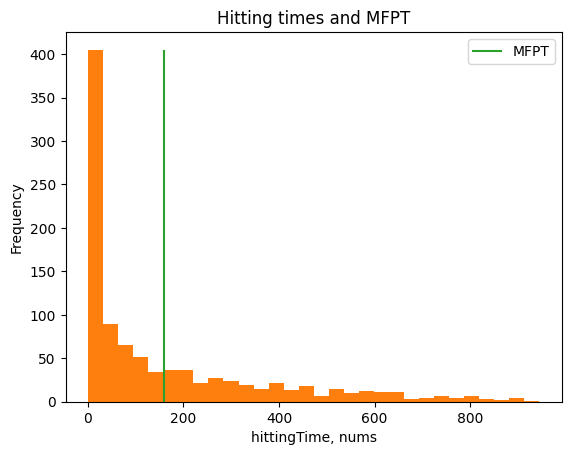

In [50]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

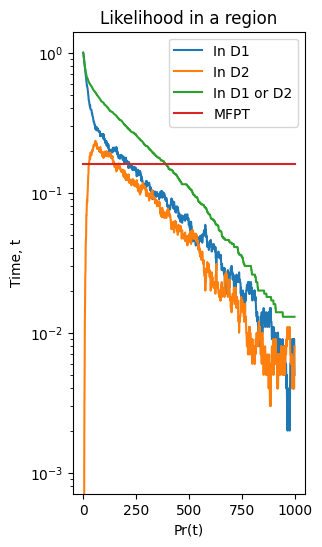

In [51]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

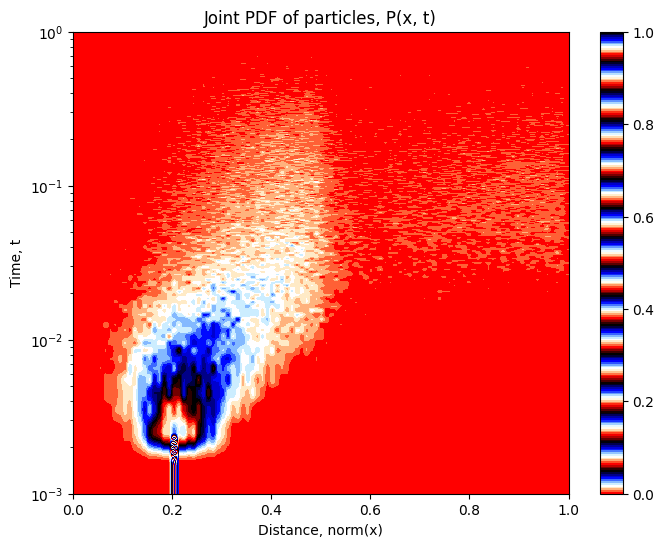

In [52]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 1.1, D2 = 1

#Simulate Ito Convention

In [53]:
#Diffusivity of inner medium
D1 = 1.1
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [54]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 4.6838085651397705 seconds ---


# Plots

Mean First Passage Time =  128.77304964539007


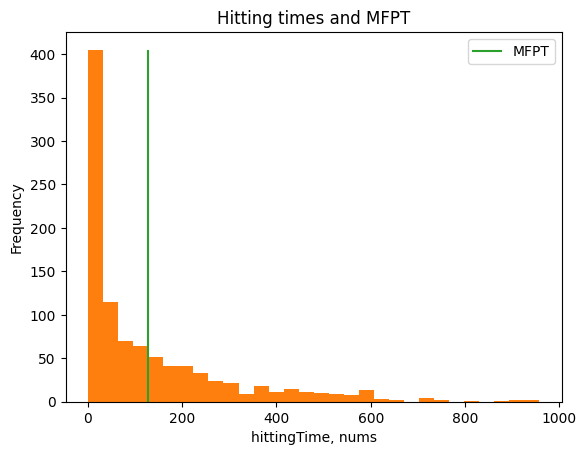

In [55]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

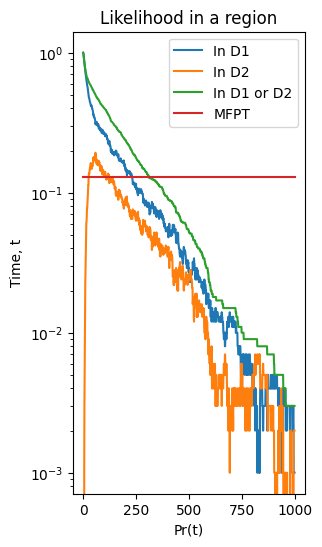

In [56]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

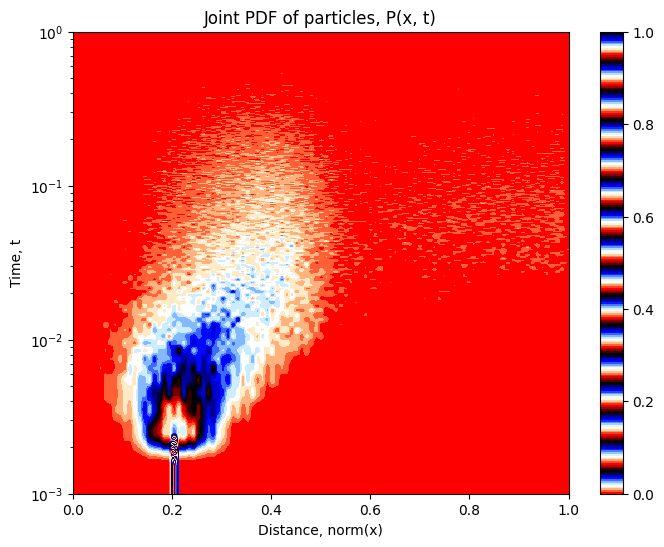

In [57]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [58]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 5.218937873840332 seconds ---


# Plots

Mean First Passage Time =  158.44069529652353


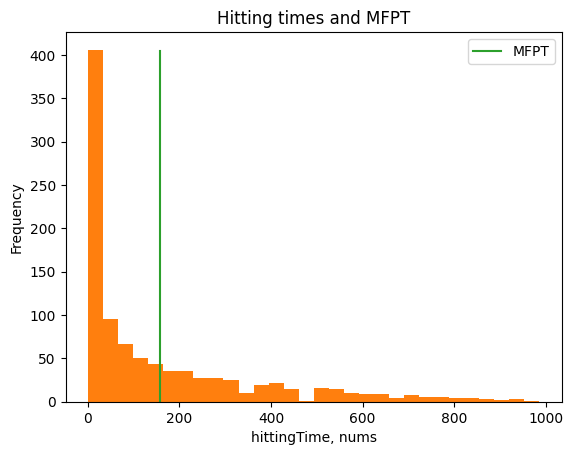

In [59]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

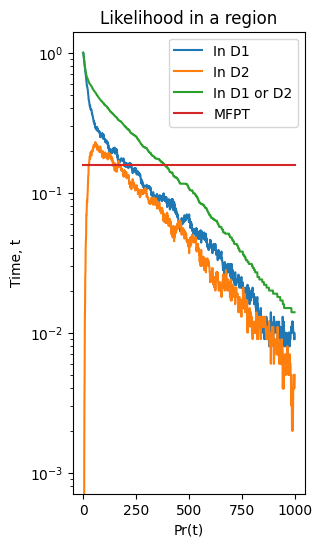

In [60]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

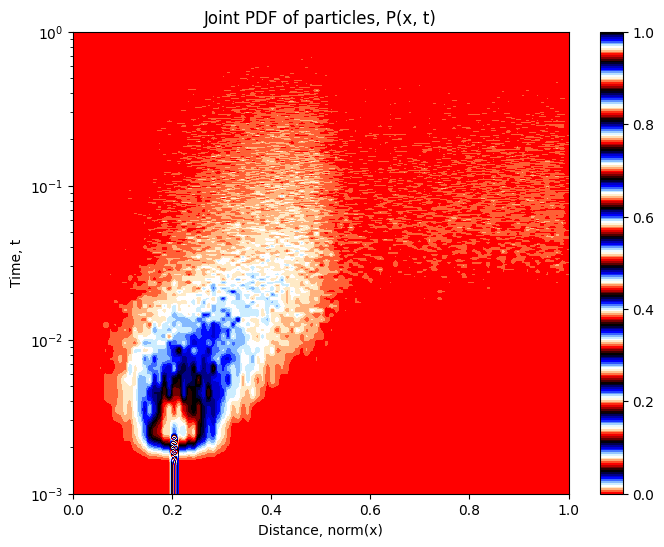

In [61]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [62]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 9.605916976928711 seconds ---


# Plots

Mean First Passage Time =  157.65301944728762


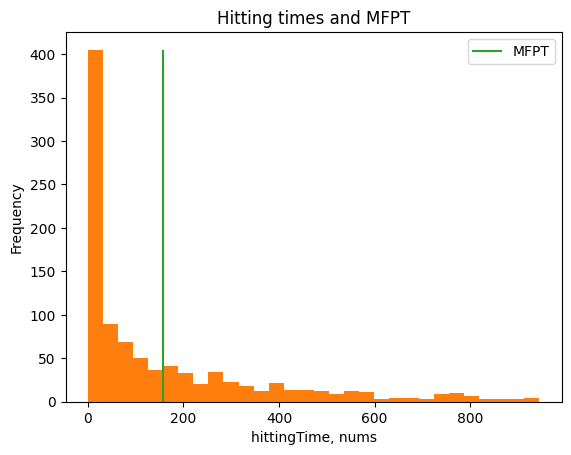

In [63]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

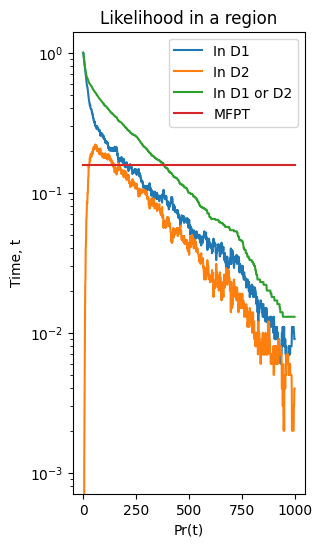

In [64]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

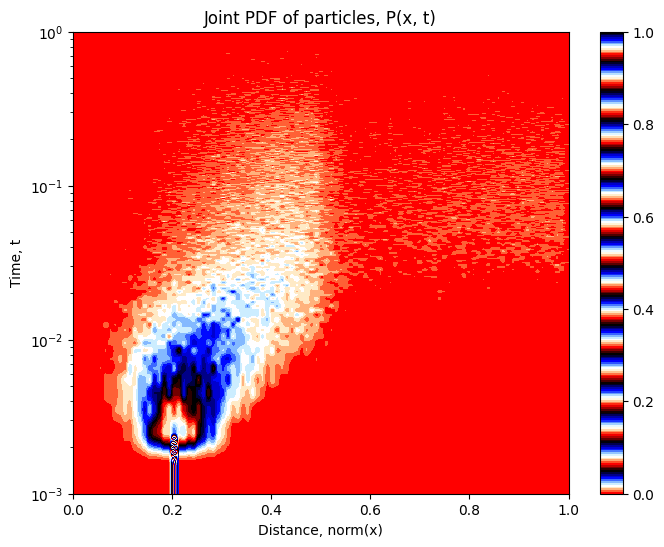

In [65]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 10, D2 = 1

#Simulate Ito Convention

In [66]:
#Diffusivity of inner medium
D1 = 10
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [67]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 4.670910358428955 seconds ---


# Plots

Mean First Passage Time =  128.77304964539007


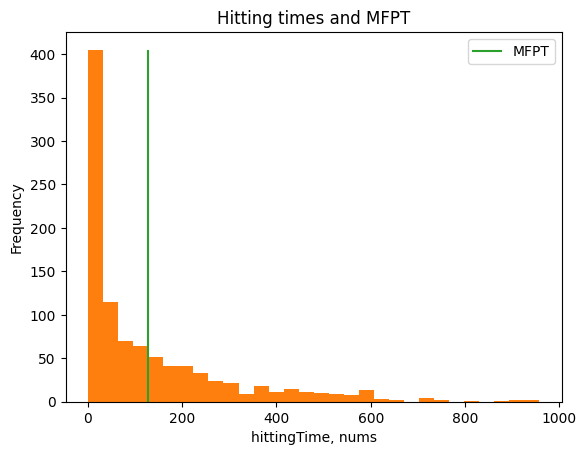

In [68]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

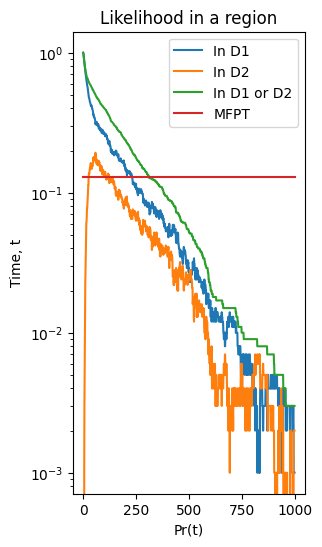

In [69]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

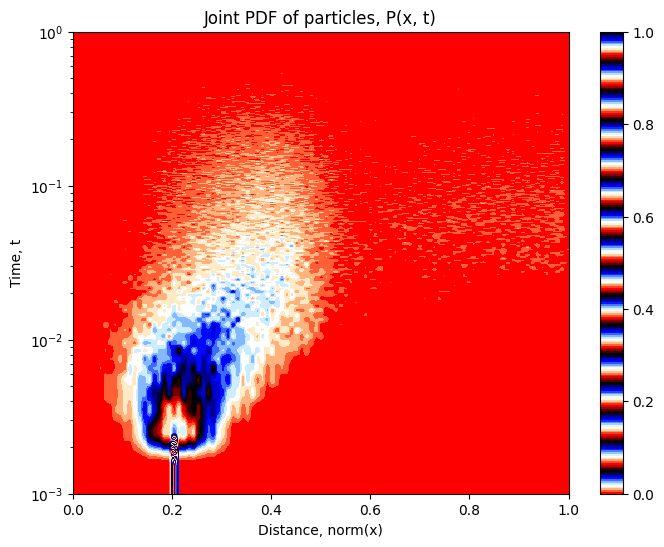

In [70]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [71]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 5.932992219924927 seconds ---


# Plots

Mean First Passage Time =  105.67368421052632


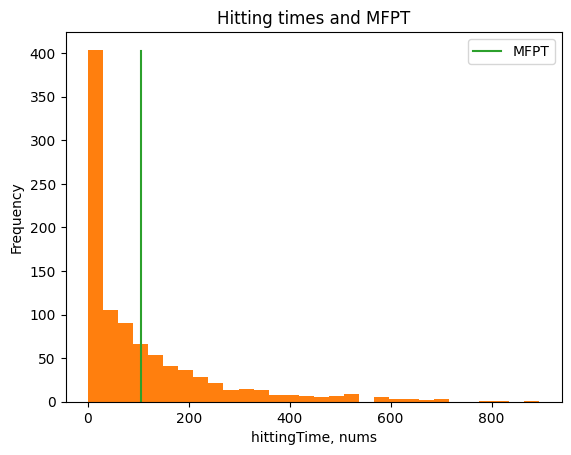

In [72]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

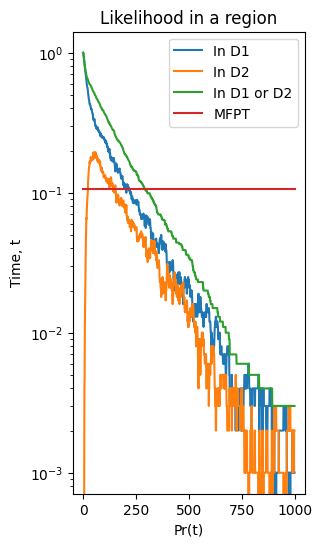

In [73]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

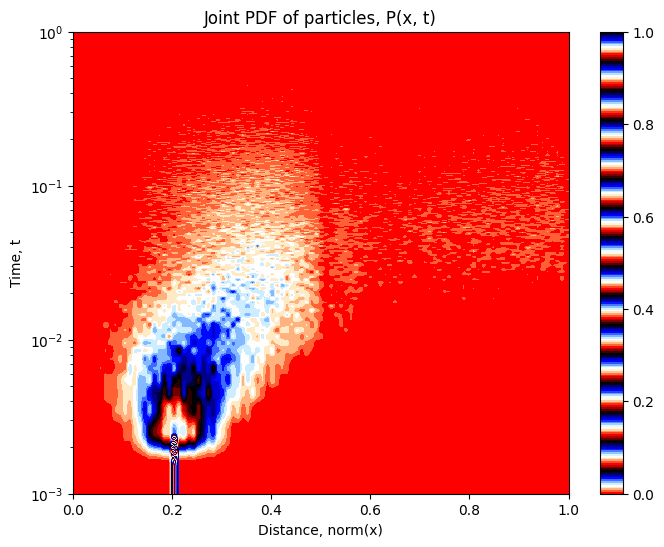

In [74]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [75]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 6.091517925262451 seconds ---


# Plots

Mean First Passage Time =  108.61088295687885


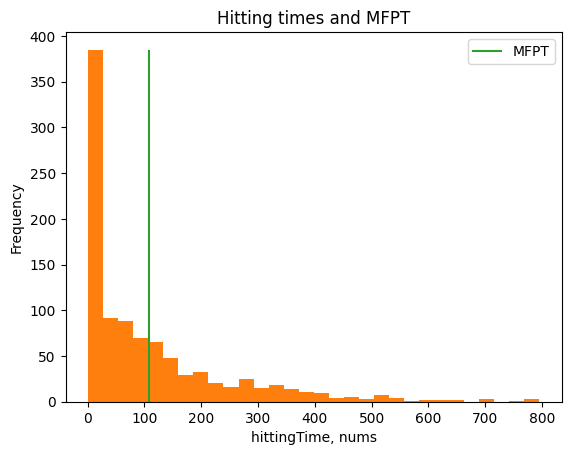

In [76]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

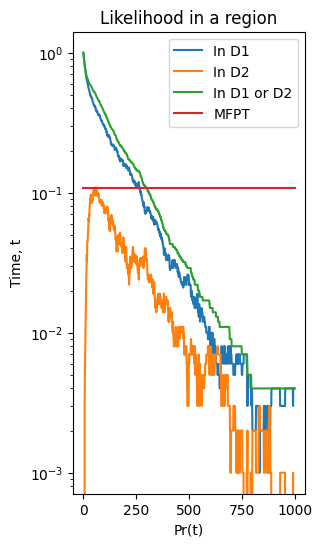

In [77]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

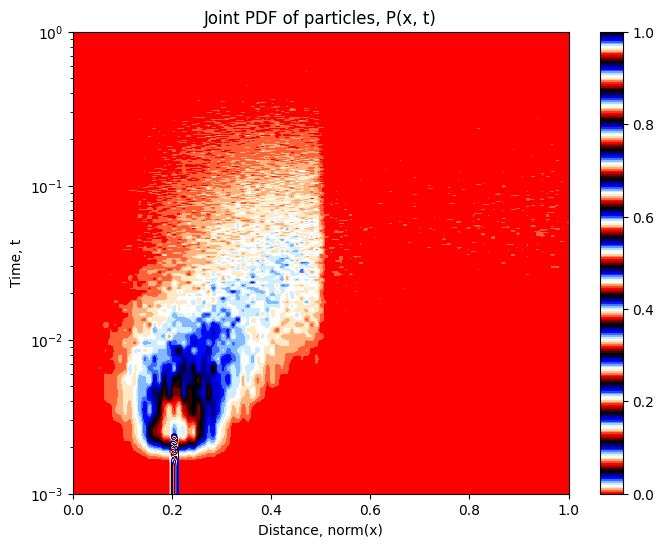

In [78]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# D1 = 100, D2 = 1

Such a large diffusivity takes the particle outside the outer reflecting boundary

Generating random numbers such that displacement is limited to the system is a hack around, but it's not really random anymore.

We get plots similar to others.

Also, putting media of such large ratios is practically insensible - Prof. Anki, 27-07-2023

#Simulate Ito Convention

In [79]:
#Diffusivity of inner medium
D1 = 100
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [80]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 4.687867641448975 seconds ---


# Plots

Mean First Passage Time =  128.77304964539007


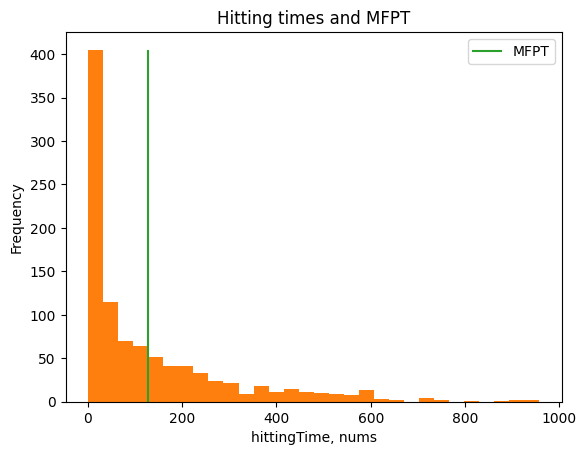

In [81]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

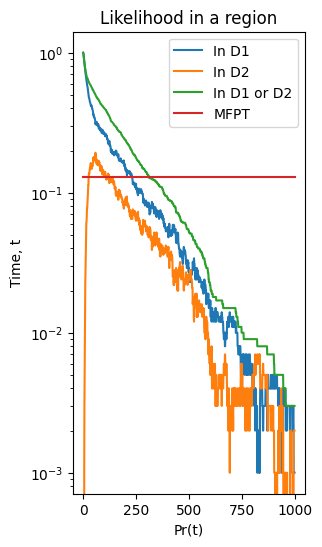

In [82]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Ito_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

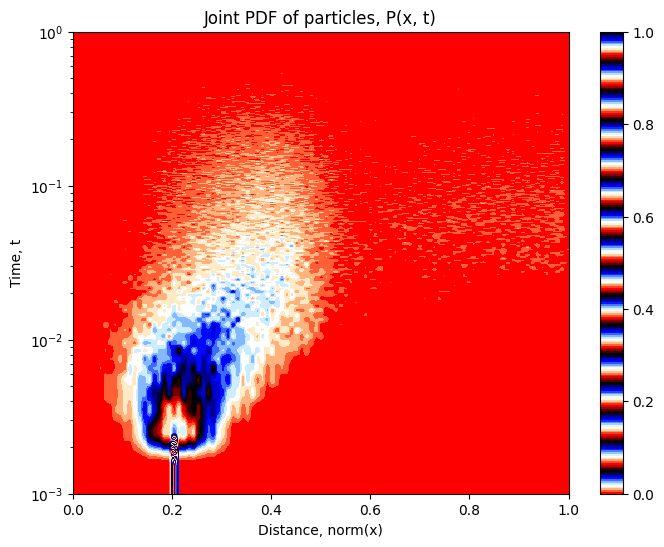

In [83]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

#Simulate Stratonovich Convention

In [84]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 10.273513793945312 seconds ---


# Plots

Mean First Passage Time =  66.4884287454324


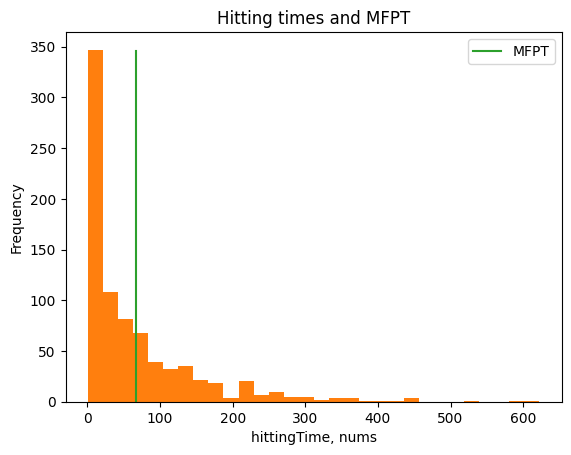

In [85]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

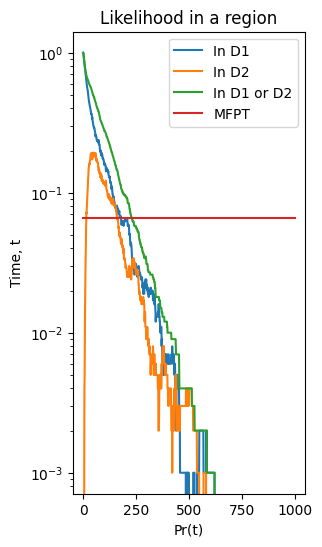

In [86]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Strat_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

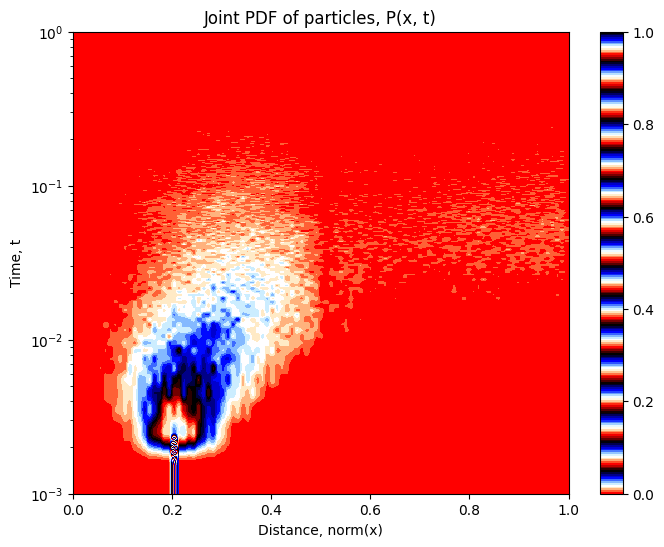

In [87]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Strat_{nump}_{nums}_{D1}_{D2}.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [88]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = -1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 6.426312446594238 seconds ---


# Plots

Mean First Passage Time =  97.37365010799137


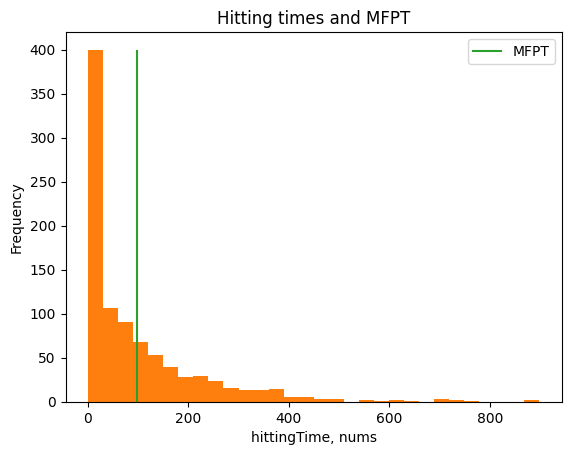

In [89]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Hist_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

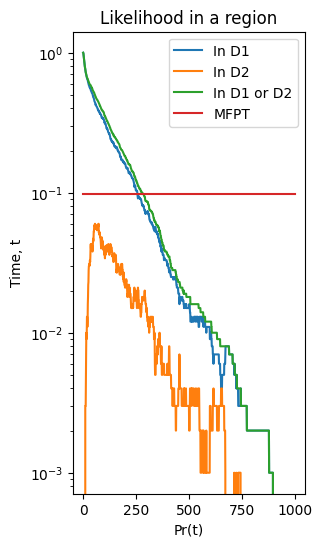

In [90]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] += np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] += np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] += np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
plt.figure(figsize = (3, 6))
plt.yscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Prob_Iso_{nump}_{nums}_{D1}_{D2}.png')
plt.show()

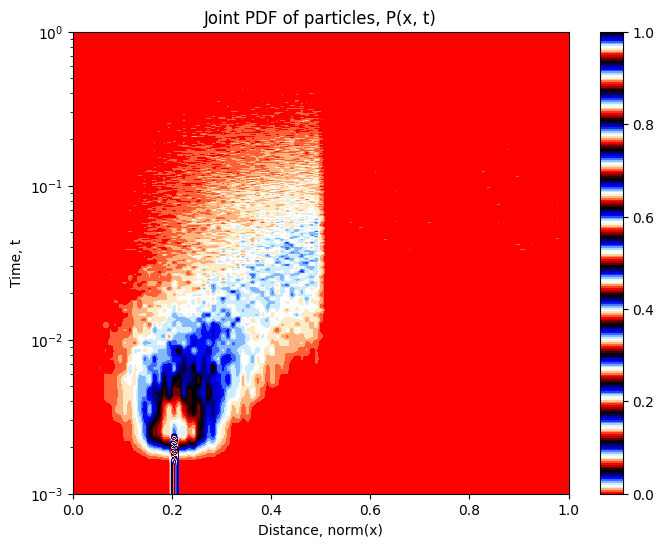

In [91]:
#Plot a heatmap of probability of particles
gridX = 100
gridT = nums
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
tim = np.linspace(0, gridT, gridT+1)
PDF1D = np.zeros((gridT, gridX+1))

#Derive a heatmap of the particles
#Find the norm of particles at each time step
Z = np.linalg.norm(Y/R2, axis=0)

#Quantize it to 2 ( = log10(gridX)) decimal places as grix X is with such precision
Z = np.round(Z, 2)

for t in range(nums):
#position of all particles at time t
  for p in range(len(pos)):
    PDF1D[t][p] = np.count_nonzero(Z[t, :] == pos[p])

#Plot the heatmap of pdf
plt.figure(figsize = (8, 6))
plt.title("Joint PDF of particles, P(x, t)")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.yscale('log')
plt.imshow(np.flipud(PDF1D/nump), cmap = 'flag', extent = [0, 1, dt, dt*nums], aspect = "auto")
plt.xlabel("Distance, norm(x)")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig(f'/content/drive/MyDrive/Images/2D/WithoutPores/Heat_Ito_{nump}_{nums}_{D1}_{D2}.png')

# Miscellaneous

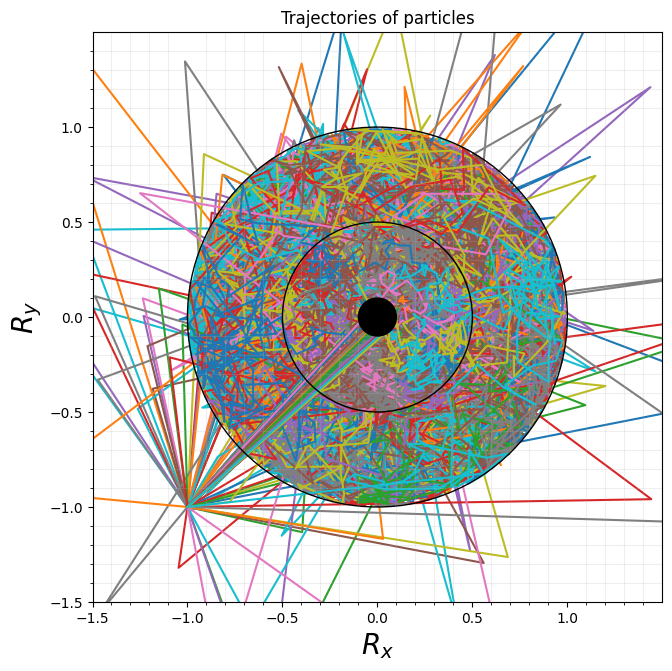

In [92]:
#WHy are some trajectories going out of the R2 boundary?

#set plot params
box=3*R2
fig,ax=plt.subplots(figsize=(7.5,7.4))
ax.set_aspect(1)
ax.set_title("Trajectories of particles")
ax.set_xlabel(r"$R_x$",fontsize=20)
ax.set_ylabel(r"$R_y$",fontsize=20)
plt.xlim(-box/2,box/2)
plt.ylim(-box/2,box/2)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-box/2, box/2, box/6)
minor_ticks = np.arange(-box/2, box/2, box/30)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid()

for i in range(nump):
  plt.plot(Y[0, :, i], Y[1, :, i], zorder=1)

ax.add_artist(plt.Circle((0, 0), R1, fill = False, zorder=2))
ax.add_artist(plt.Circle((0, 0), R2, fill = False, zorder=3))
ax.add_artist(plt.Circle((0, 0), R, fill = True, color = "k", zorder = 4))
plt.show()
#Higher zorder means the plot is on top
#https://www.pythonpool.com/matplotlib-circle/
#https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot

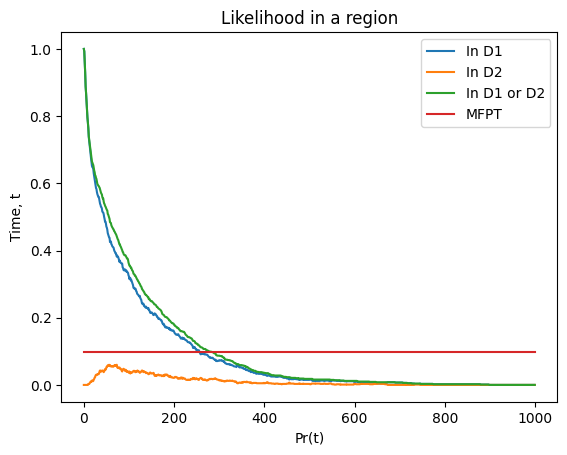

In [94]:
xticks = np.linspace(1/nums, 1, nums)
yticks = np.linspace(1/nums, 1, nums)
#plt.yscale("log")plt.figure(figsize = (3, 6))
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(np.tile(MFPT/nums, nums))
#plt.plot(count3/nump)
plt.legend(["In D1", "In D2", "In D1 or D2", "MFPT", "Hit target"])
plt.ylabel("Time, t")
plt.xlabel("Pr(t)")
plt.title("Likelihood in a region")

plt.show()

In [95]:
#print(np.linalg.norm(dX1s, axis = 2))
#print(np.linalg.norm(dX2s, axis = 2))

for p in (np.linalg.norm(dX1s, axis = 2)):
  print(max(p))
print("___")
for p in (np.linalg.norm(dX2s, axis = 2)):
  print(max(p))

"""A large D2 can push the particle out of the boundary - How to correct"""

0.185491676977254
0.1823137672848393
0.17635600401515686
0.17255187421855572
0.20608509599058059
0.1617614559553634
0.19849315458331385
0.17354196757217882
0.2023312400617964
0.15401491359936662
0.16289875880727203
0.16638493154832218
0.16564943951005587
0.16957393065097426
0.17033081142609413
0.1663173394392201
0.20773933980468562
0.16354304129573635
0.16993383274329998
0.166134267259728
0.16715707592938212
0.17590583909737315
0.1643505764942551
0.18723147598755344
0.15673924333770933
0.16922255281443296
0.17006748667572621
0.17209610944328757
0.1635945399026608
0.18108694398403424
0.18581417565851555
0.1744186015572749
0.16247116811009912
0.16953175689741795
0.1657277174349348
0.16539729571186393
0.16626261350376675
0.16756734903509268
0.1687795525648214
0.17259473300892583
0.16381182293324706
0.15888687186767342
0.20990746715953504
0.1730813465833167
0.1800380273956677
0.1709541271697173
0.16212942450557022
0.18626829710941634
0.17385146503849983
0.18290512179362284
0.16721574742504

'A large D2 can push the particle out of the boundary - How to correct'